In [1]:
import numpy as np
import pandas as pd

In [2]:
import operator

from copy import copy

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df = pd.read_csv("../data/train.txt", sep='\t', header=None, names=["users", "items", "rank"])
df.head()

,users,items,rank
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [6]:
df["rank"].unique()

array([5, 3, 4, 1, 2])

In [7]:
n_users = df["users"].max()
n_items = df["items"].max()

In [8]:
df[["users", "items"]] -= 1
df.head()

,users,items,rank
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3


In [9]:
def score(matrix, values):
    y_pred = [matrix[user, item] for user, item, rank in values]
    y_true = map(operator.itemgetter(2), values)
    return mean_squared_error(y_true, y_pred)

In [10]:
def iter_step(weights, df_grouped, C):
    weights_ = copy(weights)
    
    for user, group in df_grouped["users"]:
        Q = weights_["items"][group["items"].values]
        r = group["rank"].values
        
        A = np.dot(Q.T, Q) + C * np.eye(Q.shape[1])
        b = np.dot(Q.T, r)
        
        weights_["users"][user] = np.linalg.solve(A, b)
    
    for item, group in df_grouped["items"]:
        P = weights_["users"][group["users"].values]
        r = group["rank"].values
        
        A = np.dot(P.T, P) + C * np.eye(P.shape[1])
        b = np.dot(P.T, r)
        
        weights_["items"][item] = np.linalg.solve(A, b)
    
    return weights_

In [11]:
index = np.random.permutation(df.shape[0])
alpha = int(0.8 * len(index))

df_train, df_valid = df.iloc[index[:alpha]], df.iloc[index[alpha:]]
    
df_grouped = {cat : df_train.groupby(by=cat) for cat in ["users", "items"]}

In [18]:
C = 5.0
n_features = 4

In [19]:
weights = dict()
weights["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, n_features))
weights["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, n_features))
    
scores = []
    
n_iters = 100

for i in range(n_iters):
    weigths = iter_step(weights, df_grouped, C)
            
    matrix = np.dot(weights["users"], weights["items"].T)
    scores.append(
        (score(matrix, df_train.values),
         score(matrix, df_valid.values))
    )
        
    print "\r{} of {} iters passed...".format(i + 1, n_iters),

100 of 100 iters passed...


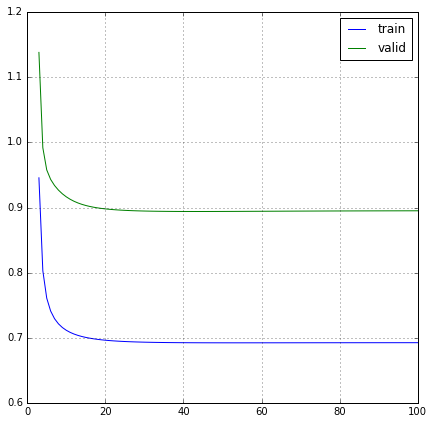

In [20]:
offset = 2

plt.figure(figsize=(7, 7))
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(0), scores)[offset:], label="train")
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(1), scores)[offset:], label="valid")
plt.legend()
plt.grid()

In [21]:
np.argsort(map(operator.itemgetter(1), scores))

array([42, 43, 41, 44, 40, 45, 46, 39, 47, 38, 48, 49, 37, 50, 36, 51, 52,
       35, 53, 54, 34, 55, 56, 57, 33, 58, 59, 60, 32, 61, 62, 63, 31, 64,
       65, 66, 67, 30, 68, 69, 70, 71, 72, 73, 29, 74, 75, 76, 77, 78, 79,
       80, 81, 28, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 27, 94,
       95, 96, 97, 98, 99, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [22]:
np.min(map(operator.itemgetter(1), scores))

0.89386235145265991

In [17]:
np.min(map(operator.itemgetter(1), scores))

0.97966518108675882